<a href="https://colab.research.google.com/github/rikieHarByHanAi/SDN-DDoS-Key-tes1/blob/main/ddos_sdn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File ada? True
Distribusi label setelah dropna:
label
1.0    380408
0.0    279276
Name: count, dtype: int64
Jumlah sampel per kelas: 2500
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.6072 - loss: 0.6086 - val_accuracy: 0.9299 - val_loss: 0.2230
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8657 - loss: 0.3703 - val_accuracy: 0.9359 - val_loss: 0.2294
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9012 - loss: 0.2907 - val_accuracy: 0.9539 - val_loss: 0.2505
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8954 - loss: 0.3141 - val_accuracy: 0.6723 - val_loss: 0.5105
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7532 - loss: 0.4519 - val_accuracy: 0.9629 - val_loss: 0.2196
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9335 - loss: 0.2403 - val_accuracy: 0.8938 - val_loss: 0.3264
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9161 - loss: 0.2777 -

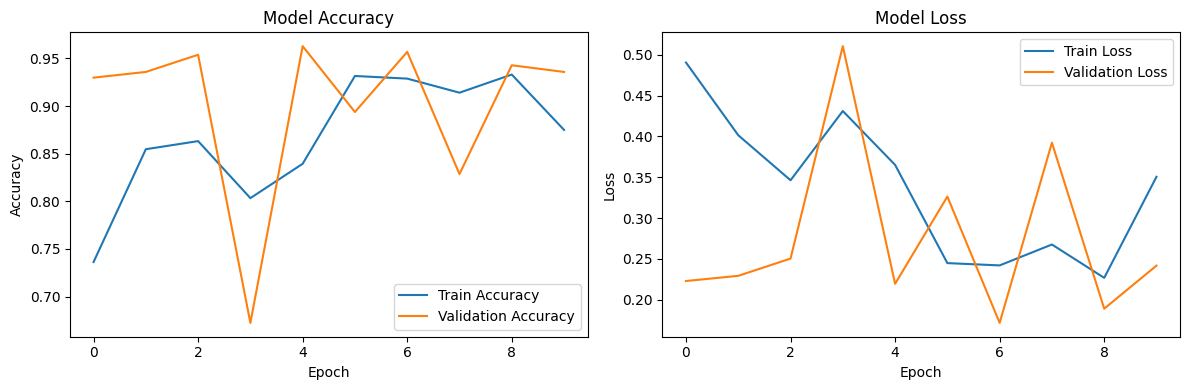

In [ ]:
# Import library
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Cek file
import os
print("File ada?", os.path.exists('SDN_DDoS.csv'))
if not os.path.exists('SDN_DDoS.csv'):
    raise FileNotFoundError("File SDN_DDoS.csv tidak ditemukan!")

# Baca dan bersihkan data
data = pd.read_csv('SDN_DDoS.csv', on_bad_lines='skip', low_memory=False)
data_clean = data[['timestamp', 'packet_count', 'byte_count',
                   'packet_count_per_second', 'byte_count_per_second', 'label']].copy()
data_clean['timestamp'] = pd.to_numeric(data_clean['timestamp'], errors='coerce')
data_clean['timestamp'] = data_clean['timestamp'] - data_clean['timestamp'].min()
data_clean = data_clean.dropna()

# Cek distribusi label
print("Distribusi label setelah dropna:")
print(data_clean['label'].value_counts())

# Ambil sampel seimbang (2,500 Normal, 2,500 DDoS)
n_sample = min(len(data_clean[data_clean['label'] == 0]),
               len(data_clean[data_clean['label'] == 1]), 2500)
print(f"Jumlah sampel per kelas: {n_sample}")
normal_data = data_clean[data_clean['label'] == 0].sample(n=n_sample, random_state=42)
ddos_data = data_clean[data_clean['label'] == 1].sample(n=n_sample, random_state=42)
data_sample = pd.concat([normal_data, ddos_data])

# Normalisasi fitur
scaler = MinMaxScaler()
fitur = ['timestamp', 'packet_count', 'byte_count',
         'packet_count_per_second', 'byte_count_per_second']
data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])

# Bikin urutan
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[fitur].iloc[i:i+seq_length].values)
        y.append(data['label'].iloc[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(data_sample, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bikin model LSTM + Attention
inputs = Input(shape=(seq_length, len(fitur)))
lstm_out = LSTM(50, return_sequences=True)(inputs)
attention_out = Attention()([lstm_out, lstm_out])
lstm_final = LSTM(50, return_sequences=False)(attention_out)
dropout = Dropout(0.2)(lstm_final)
outputs = Dense(1, activation='sigmoid')(dropout)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Latih model (10 epoch)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Cek hasil
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi di data test: {accuracy*100:.2f}%")
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'DDoS']))

# Visualisasi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

File ada? True
Distribusi label setelah dropna:
label
1    4365189
0     279276
Name: count, dtype: int64
Jumlah sampel per kelas: 5000


<ipython-input-2-8329ab48faca>:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00000000e+00 2.95310641e-05 3.38738676e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])
<ipython-input-2-8329ab48faca>:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00000000e+00 6.19676041e-08 7.10804871e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7365 - loss: 0.4802 - val_accuracy: 0.8188 - val_loss: 0.3864
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8954 - loss: 0.2843 - val_accuracy: 0.9044 - val_loss: 0.2399
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9296 - loss: 0.2112 - val_accuracy: 0.9650 - val_loss: 0.1240
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8425 - loss: 0.3635 - val_accuracy: 0.9510 - val_loss: 0.1608
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9418 - loss: 0.1985 - val_accuracy: 0.9640 - val_loss: 0.1648
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9365 - loss: 0.2065 - val_accuracy: 0.9665 - val_loss: 0.1456
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9528 - loss: 0.1752 - val_accuracy: 0.9730 - val_loss: 0.1249
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8973 - loss: 0.2728 - val_acc

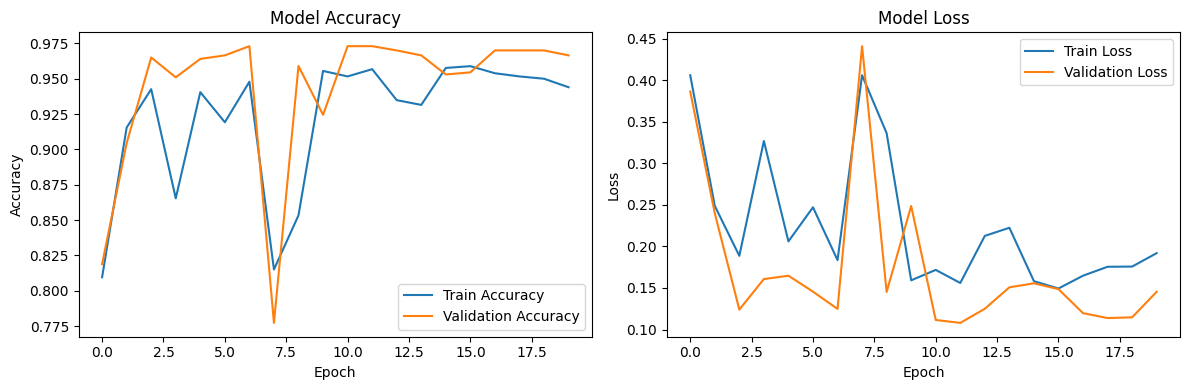

In [ ]:
# Import library
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Cek file
import os
print("File ada?", os.path.exists('SDN_DDoS.csv'))
if not os.path.exists('SDN_DDoS.csv'):
    raise FileNotFoundError("File SDN_DDoS.csv tidak ditemukan!")

# Baca dan bersihkan data
data = pd.read_csv('SDN_DDoS.csv', on_bad_lines='skip', low_memory=False)
data_clean = data[['timestamp', 'packet_count', 'byte_count',
                   'packet_count_per_second', 'byte_count_per_second', 'label']].copy()
data_clean['timestamp'] = pd.to_numeric(data_clean['timestamp'], errors='coerce')
data_clean['timestamp'] = data_clean['timestamp'] - data_clean['timestamp'].min()
data_clean = data_clean.dropna()

# Cek distribusi label
print("Distribusi label setelah dropna:")
print(data_clean['label'].value_counts())

# Ambil sampel seimbang (5,000 Normal, 5,000 DDoS)
n_sample = min(len(data_clean[data_clean['label'] == 0]),
               len(data_clean[data_clean['label'] == 1]), 5000)
print(f"Jumlah sampel per kelas: {n_sample}")
normal_data = data_clean[data_clean['label'] == 0].sample(n=n_sample, random_state=42)
ddos_data = data_clean[data_clean['label'] == 1].sample(n=n_sample, random_state=42)
data_sample = pd.concat([normal_data, ddos_data])

# Normalisasi fitur
scaler = MinMaxScaler()
fitur = ['timestamp', 'packet_count', 'byte_count',
         'packet_count_per_second', 'byte_count_per_second']
data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])

# Bikin urutan
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[fitur].iloc[i:i+seq_length].values)
        y.append(data['label'].iloc[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(data_sample, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bikin model LSTM + Attention
inputs = Input(shape=(seq_length, len(fitur)))
lstm_out = LSTM(50, return_sequences=True)(inputs)
attention_out = Attention()([lstm_out, lstm_out])
lstm_final = LSTM(50, return_sequences=False)(attention_out)
dropout = Dropout(0.2)(lstm_final)
outputs = Dense(1, activation='sigmoid')(dropout)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Latih model (20 epoch)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Cek hasil
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi di data test: {accuracy*100:.2f}%")
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'DDoS']))

# Visualisasi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

File ada? True
Distribusi label setelah dropna:
label
1    4365189
0     279276
Name: count, dtype: int64
Jumlah sampel per kelas: 10000


<ipython-input-3-da29159380c6>:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00000000e+00 2.95310641e-05 3.38738676e-05 ... 8.68560708e-07
 0.00000000e+00 0.00000000e+00]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])
<ipython-input-3-da29159380c6>:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00000000e+00 6.19676041e-08 7.10804871e-08 ... 3.01283069e-09
 0.00000000e+00 0.00000000e+00]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])


Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8081 - loss: 0.3952 - val_accuracy: 0.7419 - val_loss: 0.4781
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9053 - loss: 0.2781 - val_accuracy: 0.9297 - val_loss: 0.2278
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9386 - loss: 0.2039 - val_accuracy: 0.9047 - val_loss: 0.2859
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9236 - loss: 0.2434 - val_accuracy: 0.9617 - val_loss: 0.1349
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8269 - loss: 0.4129 - val_accuracy: 0.9527 - val_loss: 0.1541
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9061 - loss: 0.2641 - val_accuracy: 0.8419 - val_loss: 0.3629
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9179 - loss: 0.2446 - val_accuracy: 0.8952 - val_loss: 0.2953
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8482 - loss: 0.3529 - val_a

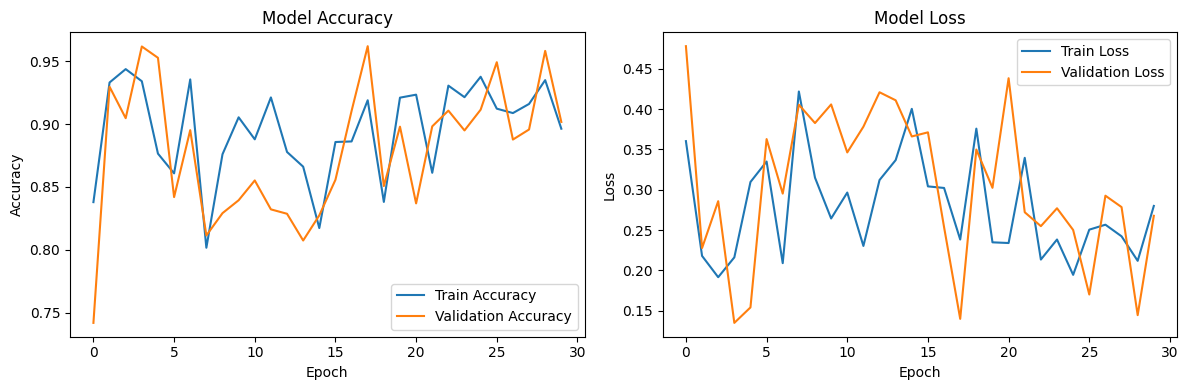

In [ ]:
# Import library
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Cek file
import os
print("File ada?", os.path.exists('SDN_DDoS.csv'))
if not os.path.exists('SDN_DDoS.csv'):
    raise FileNotFoundError("File SDN_DDoS.csv tidak ditemukan!")

# Baca dan bersihkan data
data = pd.read_csv('SDN_DDoS.csv', on_bad_lines='skip', low_memory=False)
data_clean = data[['timestamp', 'packet_count', 'byte_count',
                   'packet_count_per_second', 'byte_count_per_second', 'label']].copy()
data_clean['timestamp'] = pd.to_numeric(data_clean['timestamp'], errors='coerce')
data_clean['timestamp'] = data_clean['timestamp'] - data_clean['timestamp'].min()
data_clean = data_clean.dropna()

# Cek distribusi label
print("Distribusi label setelah dropna:")
print(data_clean['label'].value_counts())

# Ambil sampel seimbang (10,000 Normal, 10,000 DDoS)
n_sample = min(len(data_clean[data_clean['label'] == 0]),
               len(data_clean[data_clean['label'] == 1]), 10000)
print(f"Jumlah sampel per kelas: {n_sample}")
normal_data = data_clean[data_clean['label'] == 0].sample(n=n_sample, random_state=42)
ddos_data = data_clean[data_clean['label'] == 1].sample(n=n_sample, random_state=42)
data_sample = pd.concat([normal_data, ddos_data])

# Normalisasi fitur
scaler = MinMaxScaler()
fitur = ['timestamp', 'packet_count', 'byte_count',
         'packet_count_per_second', 'byte_count_per_second']
data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])

# Bikin urutan
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[fitur].iloc[i:i+seq_length].values)
        y.append(data['label'].iloc[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(data_sample, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bikin model LSTM + Attention
inputs = Input(shape=(seq_length, len(fitur)))
lstm_out = LSTM(50, return_sequences=True)(inputs)
attention_out = Attention()([lstm_out, lstm_out])
lstm_final = LSTM(50, return_sequences=False)(attention_out)
dropout = Dropout(0.2)(lstm_final)
outputs = Dense(1, activation='sigmoid')(dropout)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Latih model (30 epoch)
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Cek hasil
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi di data test: {accuracy*100:.2f}%")
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'DDoS']))

# Visualisasi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Import library
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Cek file
import os
print("File ada?", os.path.exists('SDN_DDoS.csv'))
if not os.path.exists('SDN_DDoS.csv'):
    raise FileNotFoundError("File SDN_DDoS.csv tidak ditemukan!")

# Baca dan bersihkan data
data = pd.read_csv('SDN_DDoS.csv', on_bad_lines='skip', low_memory=False)
data_clean = data[['timestamp', 'packet_count', 'byte_count',
                   'packet_count_per_second', 'byte_count_per_second', 'label']].copy()
data_clean['timestamp'] = pd.to_numeric(data_clean['timestamp'], errors='coerce')
data_clean['timestamp'] = data_clean['timestamp'] - data_clean['timestamp'].min()
data_clean = data_clean.dropna()

# Cek distribusi label
print("Distribusi label setelah dropna:")
print(data_clean['label'].value_counts())

# Ambil sampel seimbang (7,500 Normal, 7,500 DDoS)
n_sample = min(len(data_clean[data_clean['label'] == 0]),
               len(data_clean[data_clean['label'] == 1]), 7500)
print(f"Jumlah sampel per kelas: {n_sample}")
normal_data = data_clean[data_clean['label'] == 0].sample(n=n_sample, random_state=42)
ddos_data = data_clean[data_clean['label'] == 1].sample(n=n_sample, random_state=42)
data_sample = pd.concat([normal_data, ddos_data])

# Normalisasi fitur
scaler = MinMaxScaler()
fitur = ['timestamp', 'packet_count', 'byte_count',
         'packet_count_per_second', 'byte_count_per_second']
data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])

# Bikin urutan
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[fitur].iloc[i:i+seq_length].values)
        y.append(data['label'].iloc[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(data_sample, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bikin model LSTM + Attention
inputs = Input(shape=(seq_length, len(fitur)))
lstm_out = LSTM(50, return_sequences=True)(inputs)
attention_out = Attention()([lstm_out, lstm_out])
lstm_final = LSTM(50, return_sequences=False)(attention_out)
dropout = Dropout(0.2)(lstm_final)
outputs = Dense(1, activation='sigmoid')(dropout)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Latih model (25 epoch)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

# Cek hasil
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi di data test: {accuracy*100:.2f}%")
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'DDoS']))

# Visualisasi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

File ada? True
Distribusi label setelah dropna:
label
0.0    182639
Name: count, dtype: int64
Jumlah sampel per kelas: 0


ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by MinMaxScaler.

File ada? True
Distribusi label setelah dropna:
label
1.0    2123881
0.0     279276
Name: count, dtype: int64
Jumlah sampel per kelas: 7500
Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7551 - loss: 0.5002 - val_accuracy: 0.9446 - val_loss: 0.1705
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9141 - loss: 0.2458 - val_accuracy: 0.9443 - val_loss: 0.1993
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9140 - loss: 0.2551 - val_accuracy: 0.9443 - val_loss: 0.1766
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9505 - loss: 0.1704 - val_accuracy: 0.8512 - val_loss: 0.4635
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9181 - loss: 0.2504 - val_accuracy: 0.7919 - val_loss: 0.3980
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8365 - loss: 0.3379 - val_accuracy: 0.9623 - val_loss: 0.1487
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9565 - loss: 0.157

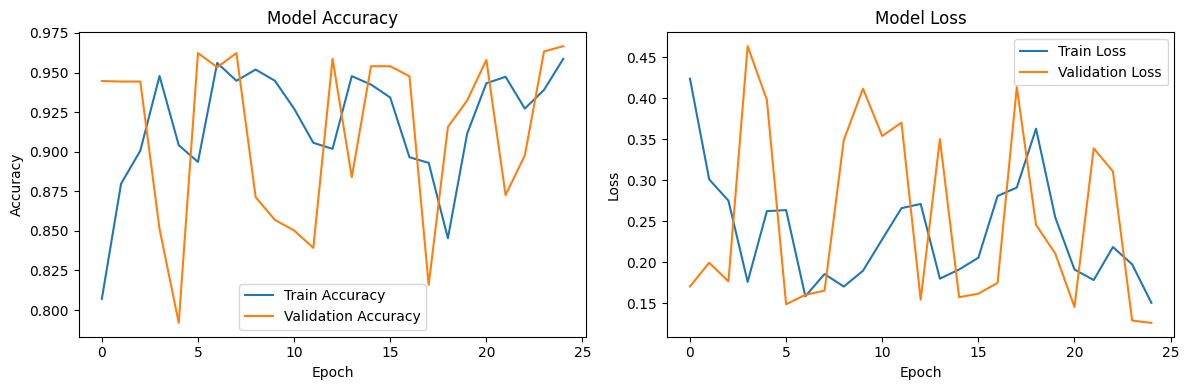

In [ ]:
# Import library
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Cek file
import os
print("File ada?", os.path.exists('SDN_DDoS.csv'))
if not os.path.exists('SDN_DDoS.csv'):
    raise FileNotFoundError("File SDN_DDoS.csv tidak ditemukan!")

# Baca dan bersihkan data
data = pd.read_csv('SDN_DDoS.csv', on_bad_lines='skip', low_memory=False)
data_clean = data[['timestamp', 'packet_count', 'byte_count',
                   'packet_count_per_second', 'byte_count_per_second', 'label']].copy()
data_clean['timestamp'] = pd.to_numeric(data_clean['timestamp'], errors='coerce')
data_clean['timestamp'] = data_clean['timestamp'] - data_clean['timestamp'].min()
data_clean = data_clean.dropna()

# Cek distribusi label
print("Distribusi label setelah dropna:")
print(data_clean['label'].value_counts())

# Ambil sampel seimbang (7,500 Normal, 7,500 DDoS)
n_sample = min(len(data_clean[data_clean['label'] == 0]),
               len(data_clean[data_clean['label'] == 1]), 7500)
print(f"Jumlah sampel per kelas: {n_sample}")
normal_data = data_clean[data_clean['label'] == 0].sample(n=n_sample, random_state=42)
ddos_data = data_clean[data_clean['label'] == 1].sample(n=n_sample, random_state=42)
data_sample = pd.concat([normal_data, ddos_data])

# Normalisasi fitur
scaler = MinMaxScaler()
fitur = ['timestamp', 'packet_count', 'byte_count',
         'packet_count_per_second', 'byte_count_per_second']
data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])

# Bikin urutan
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[fitur].iloc[i:i+seq_length].values)
        y.append(data['label'].iloc[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(data_sample, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bikin model LSTM + Attention
inputs = Input(shape=(seq_length, len(fitur)))
lstm_out = LSTM(50, return_sequences=True)(inputs)
attention_out = Attention()([lstm_out, lstm_out])
lstm_final = LSTM(50, return_sequences=False)(attention_out)
dropout = Dropout(0.2)(lstm_final)
outputs = Dense(1, activation='sigmoid')(dropout)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Latih model (25 epoch)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

# Cek hasil
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi di data test: {accuracy*100:.2f}%")
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'DDoS']))

# Visualisasi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File ada? True
Distribusi label setelah dropna:
label
1    4365189
0     279276
Name: count, dtype: int64
Jumlah sampel per kelas: 7500


<ipython-input-4-73b9dd35938b>:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00000000e+00 2.95310641e-05 3.38738676e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])
<ipython-input-4-73b9dd35938b>:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00000000e+00 6.19676041e-08 7.10804871e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])


Epoch 1/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.8331 - loss: 0.4148 - val_accuracy: 0.9400 - val_loss: 0.1793
Epoch 2/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8564 - loss: 0.3467 - val_accuracy: 0.7969 - val_loss: 0.4680
Epoch 3/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9073 - loss: 0.3080 - val_accuracy: 0.9626 - val_loss: 0.1551
Epoch 4/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9488 - loss: 0.1797 - val_accuracy: 0.9623 - val_loss: 0.1411
Epoch 5/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9562 - loss: 0.1684 - val_accuracy: 0.9666 - val_loss: 0.1640
Epoch 6/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8450 - loss: 0.3835 - val_accuracy: 0.9623 - val_loss: 0.1341
Epoch 7/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8947 - loss: 0.2900 - val_accuracy: 0.9506 - val_loss: 0.1833
Epoch 8/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9574 - loss: 0.1645

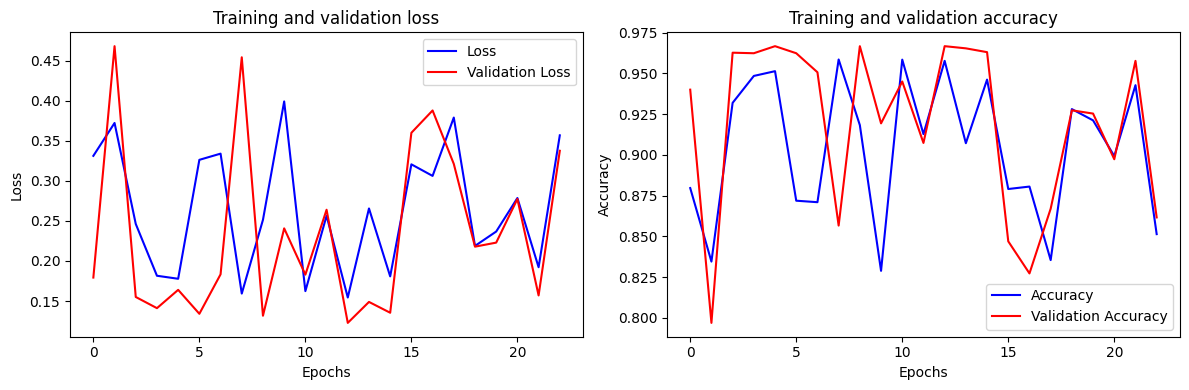

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Cek file di lokasi Google Drive
file_path = '/content/drive/MyDrive/dataSDN/SDN_DDoS.csv'
print("File ada?", os.path.exists(file_path))
if not os.path.exists(file_path):
    raise FileNotFoundError("File SDN_DDoS.csv tidak ditemukan di /content/drive/MyDrive/dataSDN/!")

# Baca dan bersihkan data
data = pd.read_csv(file_path, on_bad_lines='skip', low_memory=False)
data_clean = data[['timestamp', 'packet_count', 'byte_count',
                   'packet_count_per_second', 'byte_count_per_second', 'label']].copy()
data_clean['timestamp'] = pd.to_numeric(data_clean['timestamp'], errors='coerce')
data_clean['timestamp'] = data_clean['timestamp'] - data_clean['timestamp'].min()
data_clean = data_clean.dropna()

# Cek distribusi label
print("Distribusi label setelah dropna:")
print(data_clean['label'].value_counts())

# Ambil sampel seimbang (7,500 Normal, 7,500 DDoS)
n_sample = min(len(data_clean[data_clean['label'] == 0]),
               len(data_clean[data_clean['label'] == 1]), 7500)
print(f"Jumlah sampel per kelas: {n_sample}")
normal_data = data_clean[data_clean['label'] == 0].sample(n=n_sample, random_state=42)
ddos_data = data_clean[data_clean['label'] == 1].sample(n=n_sample, random_state=42)
data_sample = pd.concat([normal_data, ddos_data])

# Normalisasi fitur
scaler = MinMaxScaler()
fitur = ['timestamp', 'packet_count', 'byte_count',
         'packet_count_per_second', 'byte_count_per_second']
data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])

# Bikin urutan
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[fitur].iloc[i:i+seq_length].values)
        y.append(data['label'].iloc[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(data_sample, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bikin model LSTM + Attention
inputs = Input(shape=(seq_length, len(fitur)))
lstm_out = LSTM(50, return_sequences=True)(inputs)
attention_out = Attention()([lstm_out, lstm_out])
lstm_final = LSTM(50, return_sequences=False)(attention_out)
dropout = Dropout(0.2)(lstm_final)
outputs = Dense(1, activation='sigmoid')(dropout)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Latih model (250 epoch)
history = model.fit(X_train, y_train, epochs=250, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

# Cek hasil
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi di data test: {accuracy*100:.2f}%")
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'DDoS']))

# Visualisasi mirip gambar Anda
plt.style.use('default')
plt.figure(figsize=(12, 4))

# Grafik Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Grafik Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File ada? True
Distribusi label setelah dropna:
label
1    4365189
0     279276
Name: count, dtype: int64
Jumlah sampel per kelas: 7500


<ipython-input-5-e6ac841a762b>:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00000000e+00 2.95310641e-05 3.38738676e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])
<ipython-input-5-e6ac841a762b>:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00000000e+00 6.19676041e-08 7.10804871e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])


Epoch 1/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8007 - loss: 0.4066 - val_accuracy: 0.9506 - val_loss: 0.1571
Epoch 2/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7548 - loss: 0.5414 - val_accuracy: 0.9476 - val_loss: 0.1716
Epoch 3/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9447 - loss: 0.1934 - val_accuracy: 0.9396 - val_loss: 0.1874
Epoch 4/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9492 - loss: 0.1767 - val_accuracy: 0.9486 - val_loss: 0.1661
Epoch 5/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9437 - loss: 0.1891 - val_accuracy: 0.9666 - val_loss: 0.1428
Epoch 6/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9501 - loss: 0.1755 - val_accuracy: 0.7065 - val_loss: 0.6299
Epoch 7/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7405 - loss: 0.5047 - val_accuracy: 0.9586 - val_loss: 0.1628
Epoch 8/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9381 - loss: 0.198

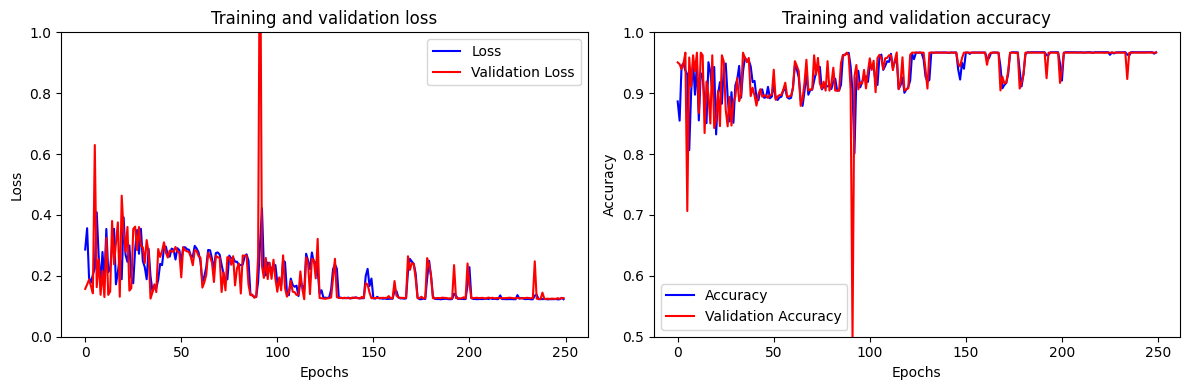

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Cek file di lokasi Google Drive
file_path = '/content/drive/MyDrive/dataSDN/SDN_DDoS.csv'
print("File ada?", os.path.exists(file_path))
if not os.path.exists(file_path):
  raise FileNotFoundError("File SDN_DDoS.csv tidak ditemukan di /content/drive/MyDrive/dataSDN/!")

# Baca dan bersihkan data
data = pd.read_csv(file_path, on_bad_lines='skip', low_memory=False)
data_clean = data[['timestamp', 'packet_count', 'byte_count',
                 'packet_count_per_second', 'byte_count_per_second', 'label']].copy()
data_clean['timestamp'] = pd.to_numeric(data_clean['timestamp'], errors='coerce')
data_clean['timestamp'] = data_clean['timestamp'] - data_clean['timestamp'].min()
data_clean = data_clean.dropna()

# Cek distribusi label
print("Distribusi label setelah dropna:")
print(data_clean['label'].value_counts())

# Ambil sampel seimbang (7,500 Normal, 7,500 DDoS)
n_sample = min(len(data_clean[data_clean['label'] == 0]),
             len(data_clean[data_clean['label'] == 1]), 7500)
print(f"Jumlah sampel per kelas: {n_sample}")
normal_data = data_clean[data_clean['label'] == 0].sample(n=n_sample, random_state=42)
ddos_data = data_clean[data_clean['label'] == 1].sample(n=n_sample, random_state=42)
data_sample = pd.concat([normal_data, ddos_data])

# Normalisasi fitur
scaler = MinMaxScaler()
fitur = ['timestamp', 'packet_count', 'byte_count',
       'packet_count_per_second', 'byte_count_per_second']
data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])

# Bikin urutan
def create_sequences(data, seq_length):
  X, y = [], []
  for i in range(len(data) - seq_length):
      X.append(data[fitur].iloc[i:i+seq_length].values)
      y.append(data['label'].iloc[i+seq_length])
  return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(data_sample, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bikin model LSTM + Attention
inputs = Input(shape=(seq_length, len(fitur)))
lstm_out = LSTM(50, return_sequences=True)(inputs)
attention_out = Attention()([lstm_out, lstm_out])
lstm_final = LSTM(50, return_sequences=False)(attention_out)
dropout = Dropout(0.2)(lstm_final)
outputs = Dense(1, activation='sigmoid')(dropout)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Latih model (250 epoch tanpa EarlyStopping)
history = model.fit(X_train, y_train, epochs=250, batch_size=32,
                  validation_data=(X_test, y_test))

# Cek hasil
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi di data test: {accuracy*100:.2f}%")
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'DDoS']))

# Visualisasi mirip gambar Anda
plt.style.use('default')
plt.figure(figsize=(12, 4))

# Grafik Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1.0)  # Sesuaikan skala kayak gambar Anda
plt.legend()

# Grafik Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)  # Sesuaikan skala kayak gambar Anda
plt.legend()

plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


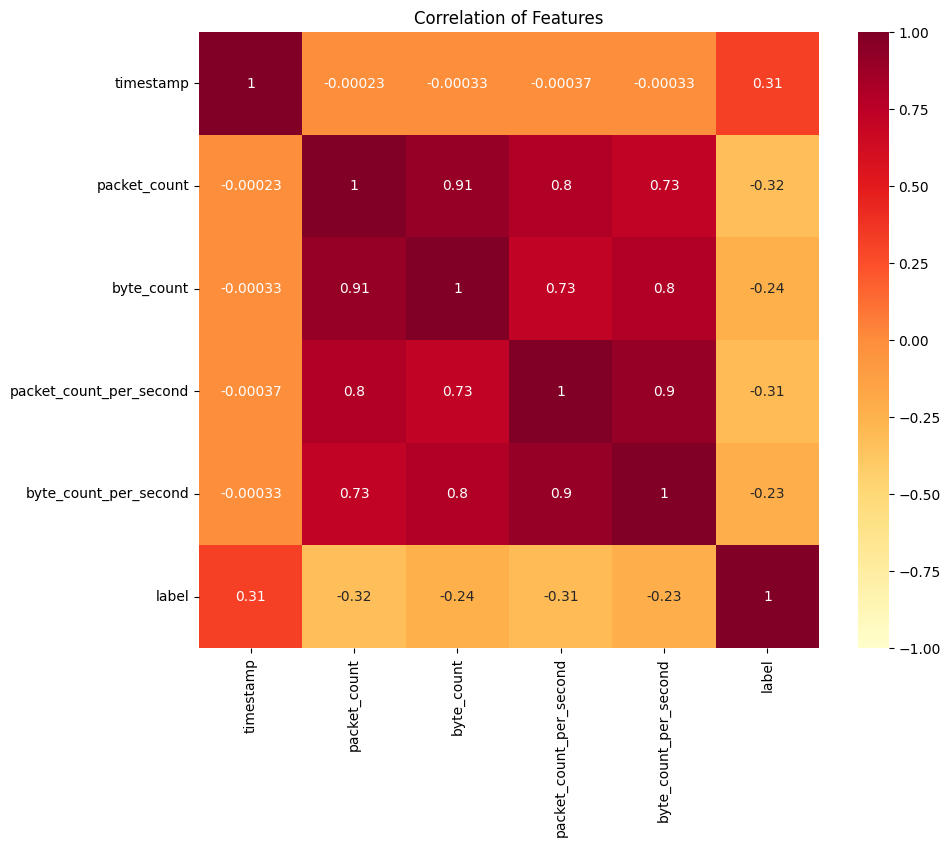

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Baca data
file_path = '/content/drive/MyDrive/dataSDN/SDN_DDoS.csv'
data = pd.read_csv(file_path, on_bad_lines='skip', low_memory=False)
data_clean = data[['timestamp', 'packet_count', 'byte_count',
                   'packet_count_per_second', 'byte_count_per_second', 'label']].dropna()

# Hitung korelasi
correlation_matrix = data_clean.corr()

# Visualisasi
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrRd', vmin=-1, vmax=1)
plt.title('Correlation of Features')
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File ada? True
Distribusi label setelah dropna:
label
1    4365189
0     279276
Name: count, dtype: int64


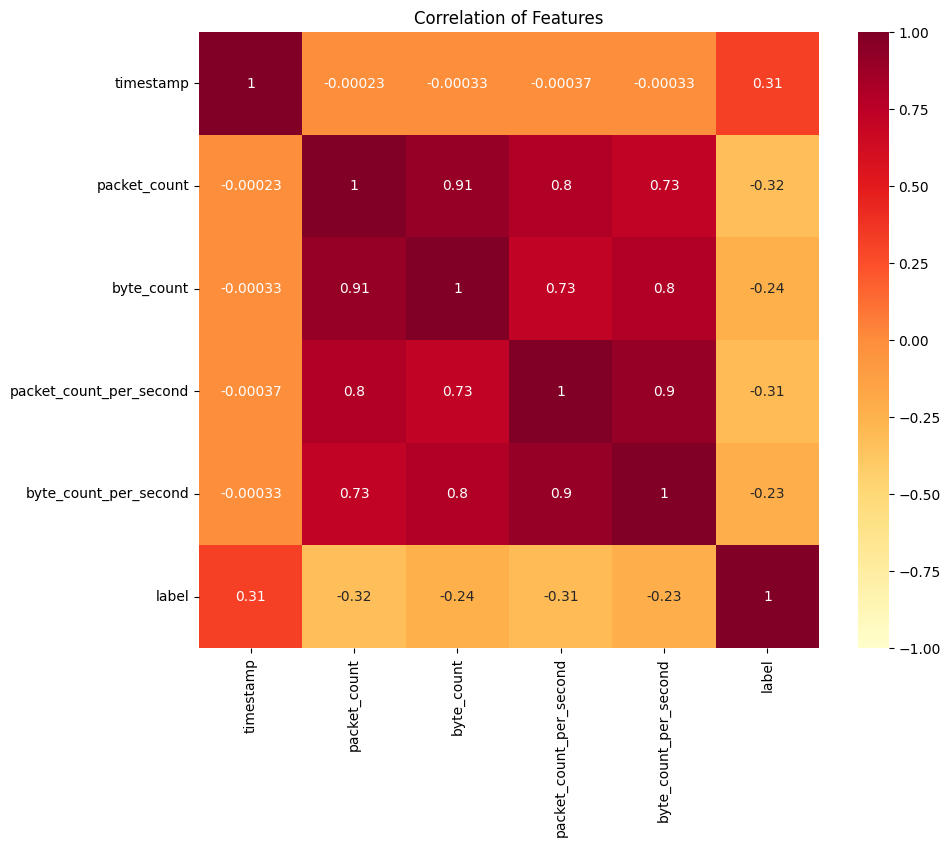

Jumlah sampel per kelas: 7500


<ipython-input-7-5f469f41debc>:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00000000e+00 2.95310641e-05 3.38738676e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])
<ipython-input-7-5f469f41debc>:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00000000e+00 6.19676041e-08 7.10804871e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])


Epoch 1/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8001 - loss: 0.3998 - val_accuracy: 0.7151 - val_loss: 0.5070
Epoch 2/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8225 - loss: 0.3630 - val_accuracy: 0.8342 - val_loss: 0.3607
Epoch 3/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9042 - loss: 0.2667 - val_accuracy: 0.9456 - val_loss: 0.2254
Epoch 4/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9459 - loss: 0.1870 - val_accuracy: 0.7121 - val_loss: 0.5285
Epoch 5/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.7337 - loss: 0.4993 - val_accuracy: 0.8916 - val_loss: 0.2966
Epoch 6/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9338 - loss: 0.2192 - val_accuracy: 0.9666 - val_loss: 0.1323
Epoch 7/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9478 - loss: 0.1730 - val_accuracy: 0.9553 - val_loss: 0.1504
Epoch 8/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9251 - loss: 0.2216 -

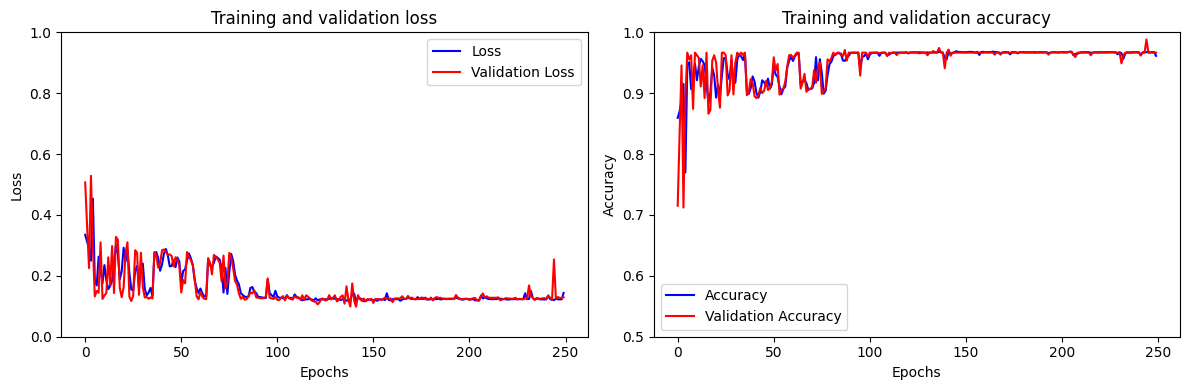

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/dataSDN/SDN_DDoS.csv'
print("File ada?", os.path.exists(file_path))
if not os.path.exists(file_path):
    raise FileNotFoundError("File SDN_DDoS.csv tidak ditemukan!")

# Baca dan bersihkan data
data = pd.read_csv(file_path, on_bad_lines='skip')
data_clean = data[['timestamp', 'packet_count', 'byte_count',
                   'packet_count_per_second', 'byte_count_per_second', 'label']].copy()
data_clean['timestamp'] = pd.to_numeric(data_clean['timestamp'], errors='coerce')
data_clean['timestamp'] = data_clean['timestamp'] - data_clean['timestamp'].min()
data_clean = data_clean.dropna()

print("Distribusi label setelah dropna:")
print(data_clean['label'].value_counts())

# Correlation Matrix
correlation_matrix = data_clean.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrRd', vmin=-1, vmax=1)
plt.title('Correlation of Features')
plt.show()

# Ambil sampel seimbang
n_sample = min(len(data_clean[data_clean['label'] == 0]),
               len(data_clean[data_clean['label'] == 1]), 7500)
print(f"Jumlah sampel per kelas: {n_sample}")
normal_data = data_clean[data_clean['label'] == 0].sample(n=n_sample, random_state=42)
ddos_data = data_clean[data_clean['label'] == 1].sample(n=n_sample, random_state=42)
data_sample = pd.concat([normal_data, ddos_data])

# Normalisasi fitur
scaler = MinMaxScaler()
fitur = ['timestamp', 'packet_count', 'byte_count',
         'packet_count_per_second', 'byte_count_per_second']
data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])

# Bikin urutan
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[fitur].iloc[i:i+seq_length].values)
        y.append(data['label'].iloc[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(data_sample, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bikin model
inputs = Input(shape=(seq_length, len(fitur)))
lstm_out = LSTM(50, return_sequences=True)(inputs)
attention_out = Attention()([lstm_out, lstm_out])
lstm_final = LSTM(50, return_sequences=False)(attention_out)
dropout = Dropout(0.2)(lstm_final)
outputs = Dense(1, activation='sigmoid')(dropout)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Latih model
history = model.fit(X_train, y_train, epochs=250, batch_size=32,
                    validation_data=(X_test, y_test))

# Cek hasil
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi di data test: {accuracy*100:.2f}%")
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'DDoS']))

# Visualisasi
plt.style.use('default')
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1.0)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File ada? True
Distribusi label setelah dropna:
label
1    4365189
0     279276
Name: count, dtype: int64


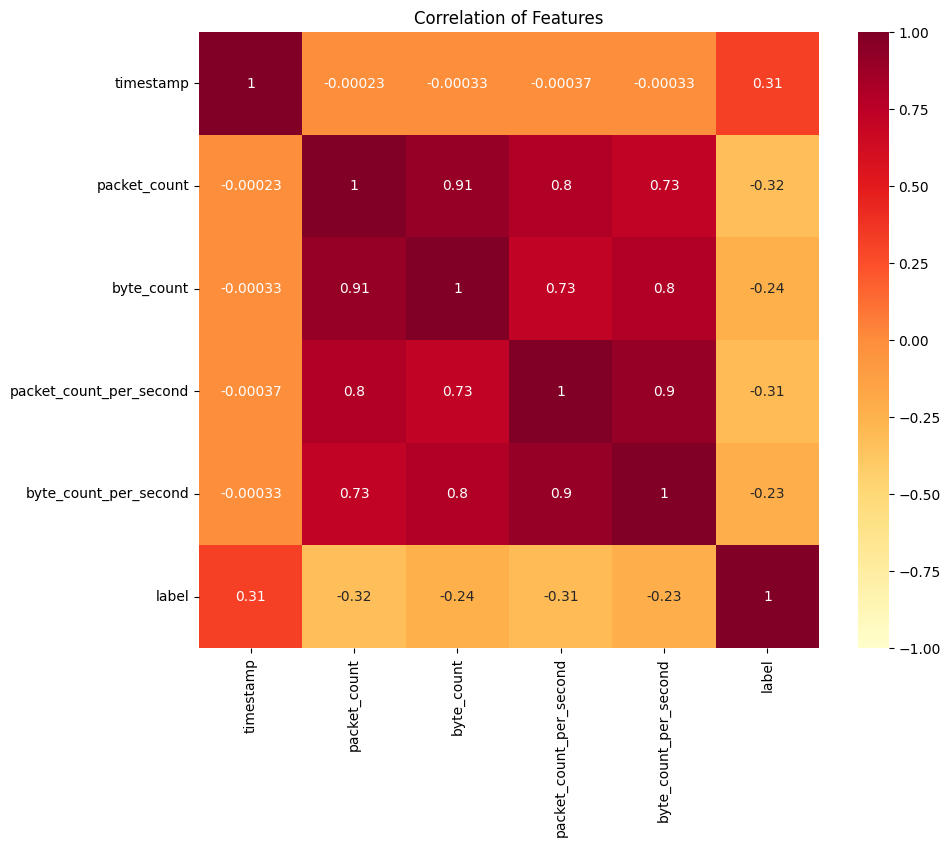

Jumlah sampel per kelas: 7500


<ipython-input-8-692bed6dc79a>:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00000000e+00 2.95310641e-05 3.38738676e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])
<ipython-input-8-692bed6dc79a>:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00000000e+00 6.19676041e-08 7.10804871e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])


Epoch 1/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7760 - loss: 0.4640 - val_accuracy: 0.9079 - val_loss: 0.2629
Epoch 2/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9012 - loss: 0.2642 - val_accuracy: 0.9583 - val_loss: 0.1935
Epoch 3/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9428 - loss: 0.2049 - val_accuracy: 0.9326 - val_loss: 0.2033
Epoch 4/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9495 - loss: 0.1782 - val_accuracy: 0.9623 - val_loss: 0.1421
Epoch 5/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9420 - loss: 0.1925 - val_accuracy: 0.8165 - val_loss: 0.3936
Epoch 6/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8979 - loss: 0.2694 - val_accuracy: 0.9370 - val_loss: 0.2035
Epoch 7/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9128 - loss: 0.2583 - val_accuracy: 0.8913 - val_loss: 0.3433
Epoch 8/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9397 - loss: 0.1997

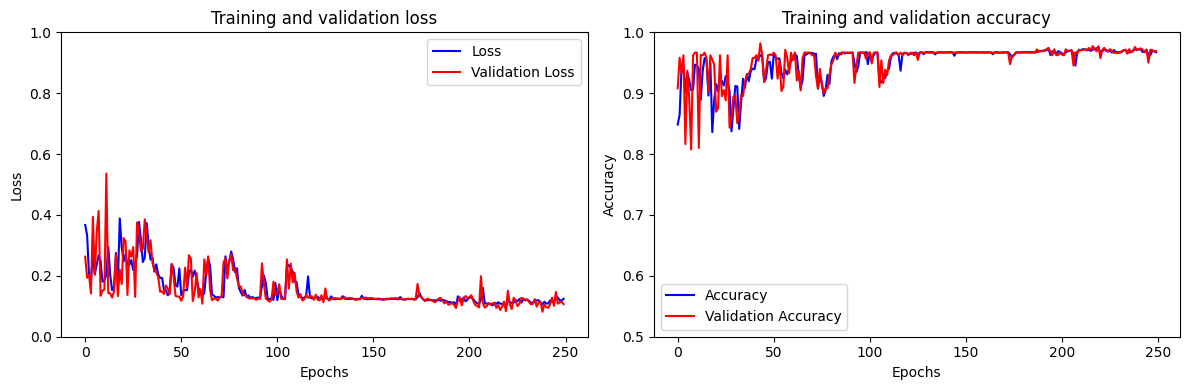

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


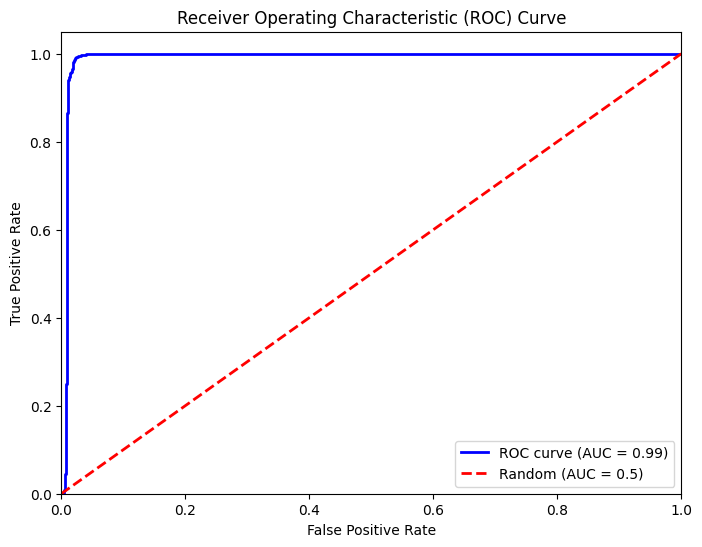

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/dataSDN/SDN_DDoS.csv'
print("File ada?", os.path.exists(file_path))
if not os.path.exists(file_path):
    raise FileNotFoundError("File SDN_DDoS.csv tidak ditemukan!")

# Baca dan bersihkan data
data = pd.read_csv(file_path, on_bad_lines='skip')
data_clean = data[['timestamp', 'packet_count', 'byte_count',
                   'packet_count_per_second', 'byte_count_per_second', 'label']].copy()
data_clean['timestamp'] = pd.to_numeric(data_clean['timestamp'], errors='coerce')
data_clean['timestamp'] = data_clean['timestamp'] - data_clean['timestamp'].min()
data_clean = data_clean.dropna()

print("Distribusi label setelah dropna:")
print(data_clean['label'].value_counts())

# Correlation Matrix
correlation_matrix = data_clean.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrRd', vmin=-1, vmax=1)
plt.title('Correlation of Features')
plt.show()

# Ambil sampel seimbang
n_sample = min(len(data_clean[data_clean['label'] == 0]),
               len(data_clean[data_clean['label'] == 1]), 7500)
print(f"Jumlah sampel per kelas: {n_sample}")
normal_data = data_clean[data_clean['label'] == 0].sample(n=n_sample, random_state=42)
ddos_data = data_clean[data_clean['label'] == 1].sample(n=n_sample, random_state=42)
data_sample = pd.concat([normal_data, ddos_data])

# Normalisasi fitur
scaler = MinMaxScaler()
fitur = ['timestamp', 'packet_count', 'byte_count',
         'packet_count_per_second', 'byte_count_per_second']
data_sample.loc[:, fitur] = scaler.fit_transform(data_sample[fitur])

# Bikin urutan
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[fitur].iloc[i:i+seq_length].values)
        y.append(data['label'].iloc[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(data_sample, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bikin model
inputs = Input(shape=(seq_length, len(fitur)))
lstm_out = LSTM(50, return_sequences=True)(inputs)
attention_out = Attention()([lstm_out, lstm_out])
lstm_final = LSTM(50, return_sequences=False)(attention_out)
dropout = Dropout(0.2)(lstm_final)
outputs = Dense(1, activation='sigmoid')(dropout)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Latih model
history = model.fit(X_train, y_train, epochs=250, batch_size=32,
                    validation_data=(X_test, y_test))

# Cek hasil
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi di data test: {accuracy*100:.2f}%")
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'DDoS']))

# Visualisasi Loss dan Accuracy
plt.style.use('default')
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1.0)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

# ROC Curve
y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

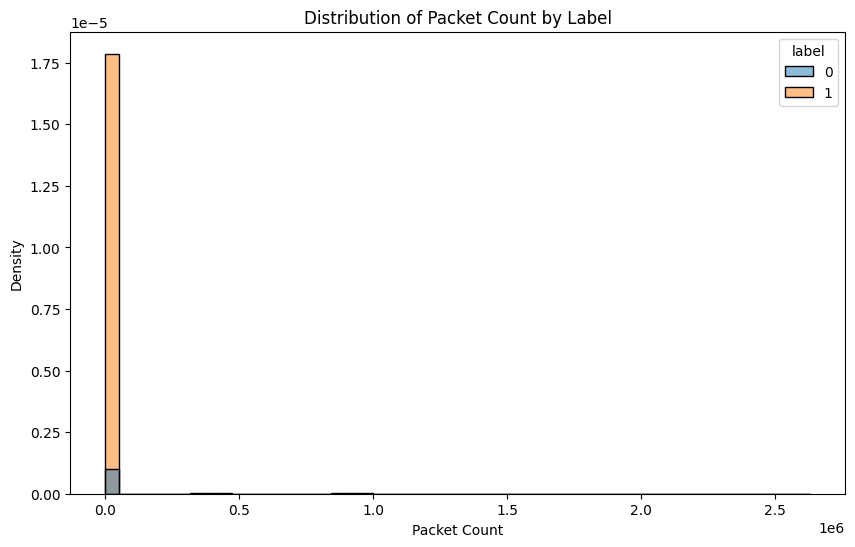

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(data=data_clean, x='packet_count', hue='label', bins=50, stat='density', alpha=0.5)
plt.title('Distribution of Packet Count by Label')
plt.xlabel('Packet Count')
plt.ylabel('Density')
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


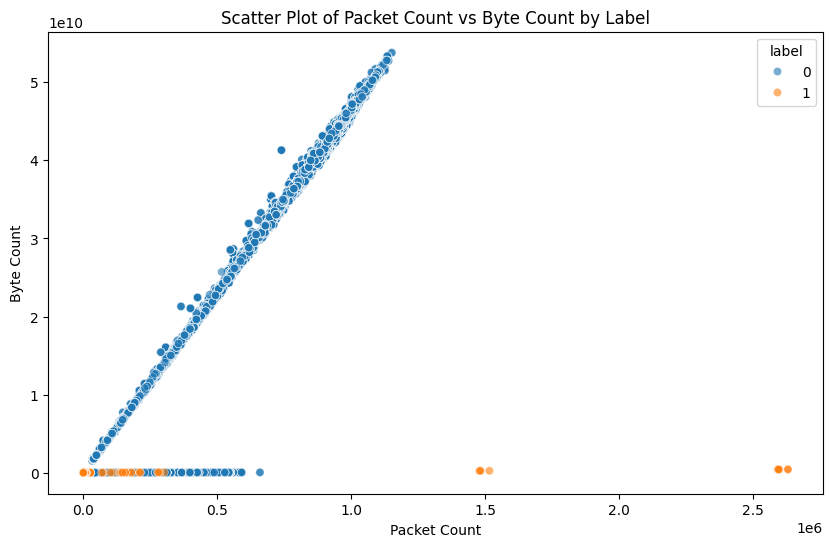

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_clean, x='packet_count', y='byte_count', hue='label', alpha=0.6)
plt.title('Scatter Plot of Packet Count vs Byte Count by Label')
plt.xlabel('Packet Count')
plt.ylabel('Byte Count')
plt.show()

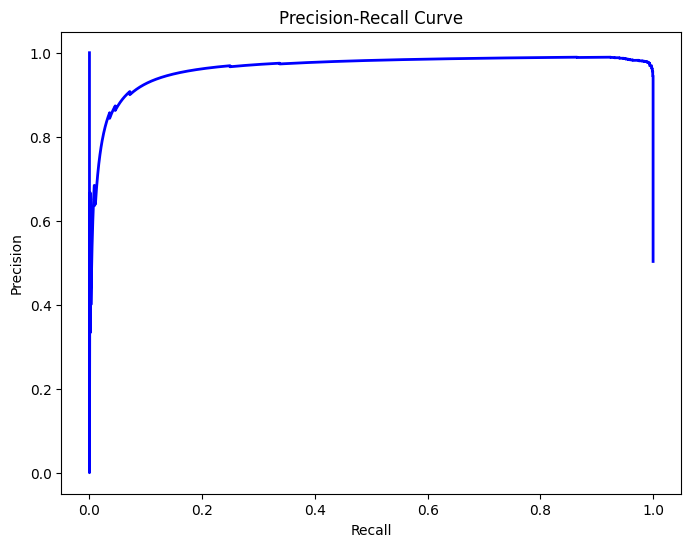

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

akurasi state of art

<ipython-input-13-e0f9b6ce1a97>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=models, palette='Blues_d')


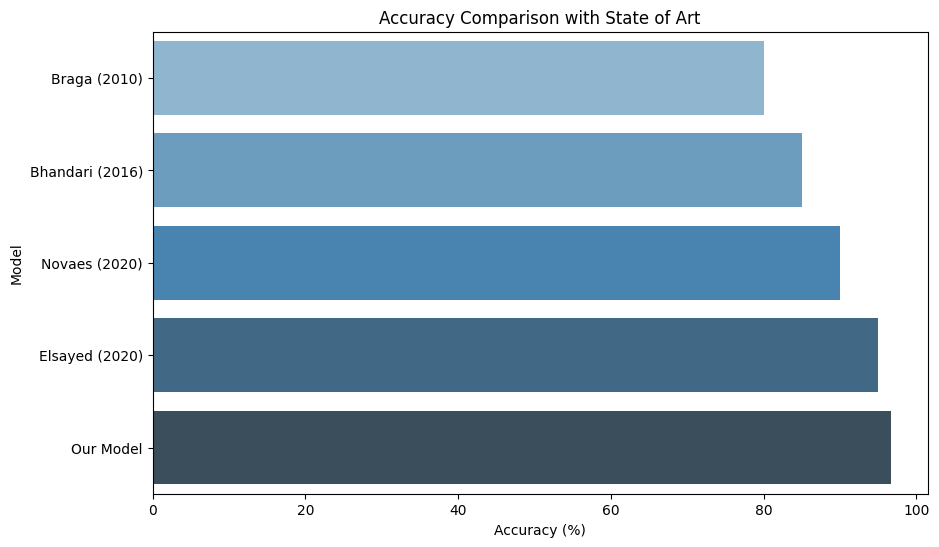

In [ ]:
models = ['Braga (2010)', 'Bhandari (2016)', 'Novaes (2020)', 'Elsayed (2020)', 'Our Model']
accuracies = [80, 85, 90, 95, 96.66]
plt.figure(figsize=(10, 6))
sns.barplot(x=accuracies, y=models, palette='Blues_d')
plt.title('Accuracy Comparison with State of Art')
plt.xlabel('Accuracy (%)')
plt.ylabel('Model')
plt.show()